In [1]:
# Performance Testing Notes and Tips

print("🎯 Files Performance Testing Tips:")
print("- File operations can be network-intensive and affected by connection quality")
print("- Upload/download speeds depend on file size, network bandwidth, and CDF limits")
print("- Consider chunked/streaming uploads for large files")
print("- Use concurrent operations carefully to avoid overwhelming the API")
print("- Test with realistic file sizes and types for your use case")
print("- Monitor your CDF file storage quota during testing")

print("\n📊 Data Modeling Integration:")
print("- File metadata is stored in the file_performance space")
print("- Each uploaded file creates both a Files API entry and a data modeling instance")
print("- Metadata queries use data modeling for enhanced filtering and aggregation")
print("- Data modeling instances link to Files API via fileId property")

print("\n📝 Next Steps:")
print("- Analyze performance patterns for your specific file types and sizes")
print("- Compare different upload/download strategies")
print("- Test with production-like file volumes")
print("- Consider file compression for better transfer performance")
print("- Plan for retry logic and error handling in production")

print("\n⚠️ Important Notes:")
print("- Remember to run cleanup at the end to avoid quota usage")
print("- Be aware of CDF file storage limits and costs")
print("- Data modeling instances also count towards your CDF limits")
print("- Test in a dedicated environment when possible")


🎯 Files Performance Testing Tips:
- File operations can be network-intensive and affected by connection quality
- Upload/download speeds depend on file size, network bandwidth, and CDF limits
- Consider chunked/streaming uploads for large files
- Use concurrent operations carefully to avoid overwhelming the API
- Test with realistic file sizes and types for your use case
- Monitor your CDF file storage quota during testing

📊 Data Modeling Integration:
- File metadata is stored in the file_performance space
- Each uploaded file creates both a Files API entry and a data modeling instance
- Metadata queries use data modeling for enhanced filtering and aggregation
- Data modeling instances link to Files API via fileId property

📝 Next Steps:
- Analyze performance patterns for your specific file types and sizes
- Compare different upload/download strategies
- Test with production-like file volumes
- Consider file compression for better transfer performance
- Plan for retry logic and error 

In [2]:
# Import required libraries
import sys
sys.path.append('../..')

from utilities.performance_utils import PerformanceTracker, benchmark_operation, generate_test_data
from configs.cdf_config import config
import pandas as pd
import numpy as np
import time
import json
import os
import tempfile
import threading
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path

try:
    from cognite.client import CogniteClient
    from cognite.client.data_classes import FileMetadata
    # Data modeling imports for metadata storage
    from cognite.client.data_classes.data_modeling import (
        NodeApply, NodeOrEdgeData, ViewId
    )
    CDF_IMPORTS_AVAILABLE = True
    print("✅ Successfully imported CDF SDK classes")
    print("   Files API and Data Modeling available for performance testing")
except ImportError as e:
    print(f"❌ CDF SDK imports not available: {e}")
    print("Please install cognite-sdk: pip install cognite-sdk --upgrade")
    CDF_IMPORTS_AVAILABLE = False

# For plotting (optional)
try:
    import matplotlib.pyplot as plt
    plt.style.use('default')
    PLOTTING_AVAILABLE = True
    print("✅ Matplotlib available for plotting")
except ImportError:
    print("⚠️  Matplotlib not available. Install with: pip install matplotlib")
    PLOTTING_AVAILABLE = False


✅ Successfully imported CDF SDK classes
   Files API and Data Modeling available for performance testing
✅ Matplotlib available for plotting


In [3]:
# Initialize CDF client using the client setup utility
from utilities.client_setup import get_client, test_connection

# Get the configured CDF client
client = get_client()

# Data modeling configuration for file performance testing
DATA_MODEL_SPACE = "file_performance"
DATA_MODEL_EXTERNAL_ID = "file_performance_model"
VIEW_EXTERNAL_ID = "FilePerformance"
VIEW_VERSION = "1"
CONTAINER_EXTERNAL_ID = "file_metadata_container"

# Flag to track if data modeling is available
USE_DATA_MODELING = False

if client is None:
    print("Failed to create CDF client. Please check your .env file.")
    print("Run: python ../../test_connection.py to test your connection")
else:
    # Test the connection
    if test_connection():
        print("Ready to run files performance tests!")
    else:
        print("Connection test failed. Please check your credentials.")


✓ Successfully connected to CDF project: templates-dev
🔍 Testing CDF connection...
📋 Current .env configuration:
----------------------------------------
  CDF_PROJECT: templates-dev
  CDF_CLUSTER: aws-dub-dev
  CDF_BASE_URL: https://aws-dub-dev.cognitedata.com
  DEFAULT_BATCH_SIZE: 1000
  DEFAULT_ITERATIONS: 10
  LOG_LEVEL: INFO
  CDF_CLIENT_ID: 8242****************************a218
  CDF_CLIENT_SECRET: KN98********************************fb.o
  CDF_TENANT_ID: b897****************************1a62
----------------------------------------
✓ Configuration is valid
✓ Successfully connected to CDF project: templates-dev
✓ Connection successful!
  Project: templates-dev
  Token is valid and accessible
Ready to run files performance tests!


In [4]:
# File Performance Testing Setup Complete
print("✅ Files performance testing setup complete!")
print("📋 You can now run the performance tests")
print("")
print("💡 Available test functions:")
print("   - File upload performance tests")
print("   - File download performance tests") 
print("   - Concurrent operations tests")
print("   - Streaming performance tests")
print("")
print("🧹 Cleanup functions are available at the end of the notebook")


✅ Files performance testing setup complete!
📋 You can now run the performance tests

💡 Available test functions:
   - File upload performance tests
   - File download performance tests
   - Concurrent operations tests
   - Streaming performance tests

🧹 Cleanup functions are available at the end of the notebook


In [5]:
# Verify client and imports are available before proceeding
if client is None:
    raise RuntimeError(
        "CDF client is not available. Cannot proceed with files performance tests.\n"
        "Please ensure your .env file is properly configured."
    )

if not CDF_IMPORTS_AVAILABLE:
    raise RuntimeError(
        "CDF SDK imports are not available. Cannot proceed with files tests.\n"
        "Please install cognite-sdk: pip install cognite-sdk --upgrade"
    )

print("🚀 Client verified. Initializing performance tracker...")

# Initialize performance tracker for files operations
tracker = PerformanceTracker("files_operations")

print("✅ Ready to run files performance tests!")
print(f"SDK version: {client.version if hasattr(client, 'version') else 'Available'}")

# Helper functions for test file generation
def create_test_file(size_mb, content_type="text", temp_dir=None):
    """Create a test file of specified size."""
    if temp_dir is None:
        temp_dir = tempfile.gettempdir()
    
    timestamp = int(time.time())
    filename = f"test_file_{size_mb}mb_{timestamp}.txt"
    filepath = os.path.join(temp_dir, filename)
    
    # Generate content based on type
    if content_type == "text":
        # Create text content
        chunk_size = 1024  # 1KB chunks
        chunks_needed = size_mb * 1024  # Total 1KB chunks needed
        
        with open(filepath, 'w') as f:
            for i in range(chunks_needed):
                # Generate varied text content
                content = f"This is test data chunk {i:06d} " * 20  # ~500 chars
                content += f"Performance testing file content {timestamp}\n"
                f.write(content[:1024])  # Ensure exactly 1KB per chunk
    
    elif content_type == "binary":
        # Create binary content
        with open(filepath, 'wb') as f:
            chunk_size = 1024 * 1024  # 1MB chunks
            for _ in range(size_mb):
                # Generate pseudo-random binary data
                data = os.urandom(chunk_size)
                f.write(data)
    
    return filepath, filename

def cleanup_local_file(filepath):
    """Clean up local test file with Windows file locking support."""
    import gc
    import platform
    
    if not os.path.exists(filepath):
        return True
    
    # For Windows, use more aggressive cleanup with retries
    if platform.system() == "Windows":
        max_retries = 5
        for attempt in range(max_retries):
            try:
                # Force garbage collection to release any file handles
                gc.collect()
                
                # Try to remove the file
                os.remove(filepath)
                return True
                
            except PermissionError as e:
                if attempt < max_retries - 1:
                    print(f"    🔄 File locked (attempt {attempt + 1}/{max_retries}), retrying in {0.5 * (attempt + 1)}s...")
                    time.sleep(0.5 * (attempt + 1))  # Exponential backoff
                    continue
                else:
                    print(f"    ⚠️ Could not delete {os.path.basename(filepath)}: File locked by another process")
                    return False
                    
            except Exception as e:
                print(f"    ⚠️ Could not delete {os.path.basename(filepath)}: {e}")
                return False
    else:
        # For Unix-like systems, use simple cleanup
        try:
            os.remove(filepath)
            return True
        except Exception as e:
            print(f"    ⚠️ Could not delete {os.path.basename(filepath)}: {e}")
            return False

# Data modeling configuration for file performance testing
DATA_MODEL_SPACE = "file_performance"
DATA_MODEL_EXTERNAL_ID = "file_performance_model"
VIEW_EXTERNAL_ID = "FilePerformance"
VIEW_VERSION = "1"

# Flag to track if data modeling is available
USE_DATA_MODELING = False

def setup_data_model():
    """Create data model space, model, and view for file performance testing."""
    global USE_DATA_MODELING
    
    if client is None:
        print("⚠️ Client not available, skipping data modeling setup")
        return False
    
    try:
        print("🔍 Setting up file performance data model...")
        
        # 1. Create space if it doesn't exist
        try:
            from cognite.client.data_classes.data_modeling import SpaceApply
            
            spaces = client.data_modeling.spaces.list()
            space_exists = any(s.space == DATA_MODEL_SPACE for s in spaces)
            
            if not space_exists:
                print(f"📦 Creating space '{DATA_MODEL_SPACE}'...")
                space = SpaceApply(
                    space=DATA_MODEL_SPACE,
                    name="File Performance Testing",
                    description="Space for file upload/download performance testing metadata"
                )
                client.data_modeling.spaces.apply([space])
                print(f"✅ Created space '{DATA_MODEL_SPACE}'")
            else:
                print(f"✅ Space '{DATA_MODEL_SPACE}' already exists")
        except Exception as e:
            print(f"❌ Failed to create space: {e}")
            return False
        
        # 2. Create container if it doesn't exist
        try:
            from cognite.client.data_classes.data_modeling import ContainerApply, ContainerProperty, Text
            
            container_id = "file_metadata_container"
            
            # List all containers and check if ours exists (same pattern as spaces)
            containers = client.data_modeling.containers.list(space=DATA_MODEL_SPACE)
            container_exists = any(c.external_id == container_id for c in containers)
            
            if not container_exists:
                print(f"📦 Creating container '{container_id}'...")
                container = ContainerApply(
                    space=DATA_MODEL_SPACE,
                    external_id=container_id,
                    name="File Metadata Container",
                    description="Container for file performance metadata",
                    properties={
                        "fileId": ContainerProperty(type=Text()),
                        "fileName": ContainerProperty(type=Text()),
                        "fileSize": ContainerProperty(type=Text()),
                        "mimeType": ContainerProperty(type=Text()),
                        "source": ContainerProperty(type=Text()),
                        "testType": ContainerProperty(type=Text()),
                        "uploadedTime": ContainerProperty(type=Text()),
                        "extractorVersion": ContainerProperty(type=Text())
                    }
                )
                client.data_modeling.containers.apply([container])
                print(f"✅ Created container '{container_id}'")
            else:
                print(f"✅ Container '{container_id}' already exists")
        except Exception as e:
            print(f"❌ Failed to create container: {e}")
            return False
        
        # 3. Create view if it doesn't exist
        view_created = False
        try:
            from cognite.client.data_classes.data_modeling import ViewApply, MappedPropertyApply, ContainerId
            
            # List all views and check if ours exists (same pattern as spaces)
            views = client.data_modeling.views.list(space=DATA_MODEL_SPACE)
            view_exists = any(v.external_id == VIEW_EXTERNAL_ID and v.version == VIEW_VERSION for v in views)
            
            if not view_exists:
                print(f"👁️ Creating view '{VIEW_EXTERNAL_ID}'...")
                
                # Create container reference
                container_ref = ContainerId(space=DATA_MODEL_SPACE, external_id=container_id)
                
                # Create view with mapped properties from container
                view = ViewApply(
                    space=DATA_MODEL_SPACE,
                    external_id=VIEW_EXTERNAL_ID,
                    version=VIEW_VERSION,
                    name="File Performance Metadata",
                    description="View for file performance testing metadata",
                    properties={
                        "fileId": MappedPropertyApply(
                            container=container_ref,
                            container_property_identifier="fileId"
                        ),
                        "fileName": MappedPropertyApply(
                            container=container_ref,
                            container_property_identifier="fileName"
                        ),
                        "fileSize": MappedPropertyApply(
                            container=container_ref,
                            container_property_identifier="fileSize"
                        ),
                        "mimeType": MappedPropertyApply(
                            container=container_ref,
                            container_property_identifier="mimeType"
                        ),
                        "source": MappedPropertyApply(
                            container=container_ref,
                            container_property_identifier="source"
                        ),
                        "testType": MappedPropertyApply(
                            container=container_ref,
                            container_property_identifier="testType"
                        ),
                        "uploadedTime": MappedPropertyApply(
                            container=container_ref,
                            container_property_identifier="uploadedTime"
                        ),
                        "extractorVersion": MappedPropertyApply(
                            container=container_ref,
                            container_property_identifier="extractorVersion"
                        )
                    }
                )
                client.data_modeling.views.apply([view])
                print(f"✅ Created view '{VIEW_EXTERNAL_ID}'")
                view_created = True
            else:
                print(f"✅ View '{VIEW_EXTERNAL_ID}' already exists")
                view_created = True
        except Exception as e:
            print(f"❌ Failed to create view: {e}")
            print(f"   Error details: {str(e)}")
            view_created = False
        
        # 4. Create data model if it doesn't exist and view was created
        if view_created:
            try:
                from cognite.client.data_classes.data_modeling import DataModelApply, ViewId
                
                # List all data models and check if ours exists (same pattern as spaces)
                models = client.data_modeling.data_models.list(space=DATA_MODEL_SPACE)
                model_exists = any(m.external_id == DATA_MODEL_EXTERNAL_ID and m.version == "1" for m in models)
                
                if not model_exists:
                    print(f"📊 Creating data model '{DATA_MODEL_EXTERNAL_ID}'...")
                    
                    # Create ViewId reference for the data model
                    view_ref = ViewId(space=DATA_MODEL_SPACE, external_id=VIEW_EXTERNAL_ID, version=VIEW_VERSION)
                    
                    data_model = DataModelApply(
                        space=DATA_MODEL_SPACE,
                        external_id=DATA_MODEL_EXTERNAL_ID,
                        version="1",
                        name="File Performance Model",
                        description="Data model for file performance testing",
                        views=[view_ref]
                    )
                    
                    result = client.data_modeling.data_models.apply([data_model])
                    print(f"✅ Created data model '{DATA_MODEL_EXTERNAL_ID}'")
                else:
                    print(f"✅ Data model '{DATA_MODEL_EXTERNAL_ID}' already exists")
                        
            except Exception as e:
                print(f"⚠️ Data model creation failed: {e}")
                print(f"   Full error: {str(e)}")
                # Continue anyway since view creation succeeded
            
        # Set final status based on view creation success
        if view_created:
            USE_DATA_MODELING = True
            print(f"🎯 Setup complete! Data modeling ENABLED ✅")
            return True
        else:
            USE_DATA_MODELING = False
            print(f"🎯 Setup complete! Data modeling DISABLED ❌")
            return False
    
    except Exception as e:
        print(f"⚠️ Error setting up data model: {e}")
        print("  Tests will run using Files API only")
        return False

def create_file_metadata_instance(file_obj, file_size_mb, test_type):
    """Create a data modeling instance for file metadata (if data modeling is available)."""
    
    # Skip if data modeling is not available
    if not USE_DATA_MODELING:
        return None
    
    try:
        timestamp = int(time.time())
        external_id = f"file_metadata_{file_obj.id}_{timestamp}"
        
        # Create the data modeling instance with file metadata
        instance = NodeApply(
            space=DATA_MODEL_SPACE,
            external_id=external_id,
            sources=[NodeOrEdgeData(
                source=ViewId(space=DATA_MODEL_SPACE, external_id=VIEW_EXTERNAL_ID, version=VIEW_VERSION),
                properties={
                    "fileId": str(file_obj.id),
                    "fileName": str(file_obj.name or ''),
                    "fileSize": str(file_size_mb),
                    "mimeType": str(getattr(file_obj, 'mime_type', 'text/plain')),
                    "source": str(getattr(file_obj, 'source', 'performance_test')),
                    "testType": str(test_type),
                    "uploadedTime": datetime.now().isoformat(),
                    "extractorVersion": "performance_test_v1.0"
                }
            )]
        )
        
        # Apply the instance to data modeling
        if client is None:
            raise RuntimeError("Client not initialized")
        result = client.data_modeling.instances.apply([instance])
        return result
        
    except Exception as e:
        print(f"Warning: Could not create data modeling instance: {e}")
        return None

# Setup data model and check availability
setup_success = setup_data_model()

# Debug: Check what was actually created
print("\n🔍 Verifying what was created...")
try:
    # Check spaces
    spaces = client.data_modeling.spaces.list()
    file_perf_spaces = [s for s in spaces if s.space == DATA_MODEL_SPACE]
    if file_perf_spaces:
        print(f"✅ Found space: {DATA_MODEL_SPACE}")
    else:
        print(f"❌ Space '{DATA_MODEL_SPACE}' not found")
        print("Available spaces:", [s.space for s in spaces][:5])
    
    # Check data models
    try:
        models = client.data_modeling.data_models.list(space=DATA_MODEL_SPACE)
        if models:
            print(f"✅ Found {len(models)} data model(s) in space '{DATA_MODEL_SPACE}':")
            for model in models:
                print(f"   - {model.external_id} (v{model.version})")
        else:
            print(f"❌ No data models found in space '{DATA_MODEL_SPACE}'")
    except Exception as e:
        print(f"⚠️ Could not list data models: {e}")
    
    # Check views
    try:
        views = client.data_modeling.views.list(space=DATA_MODEL_SPACE)
        if views:
            print(f"✅ Found {len(views)} view(s) in space '{DATA_MODEL_SPACE}':")
            for view in views:
                print(f"   - {view.external_id} (v{view.version})")
        else:
            print(f"❌ No views found in space '{DATA_MODEL_SPACE}'")
    except Exception as e:
        print(f"⚠️ Could not list views: {e}")

except Exception as e:
    print(f"❌ Error checking created resources: {e}")

print("\n🎯 Test file generation helpers ready!")
print("📁 Available test functions:")
print("  - create_test_file(size_mb, content_type='text')")
print("  - cleanup_local_file(filepath)")
print("  - create_file_metadata_instance(file_obj, file_size_mb, test_type)")
print(f"📊 Data modeling target: {DATA_MODEL_SPACE}:{VIEW_EXTERNAL_ID}/{VIEW_VERSION}")
print(f"📋 Data modeling enabled: {USE_DATA_MODELING}")


🚀 Client verified. Initializing performance tracker...
✅ Ready to run files performance tests!
SDK version: 7.76.1
🔍 Setting up file performance data model...
✅ Space 'file_performance' already exists
✅ Container 'file_metadata_container' already exists
✅ View 'FilePerformance' already exists
✅ Data model 'file_performance_model' already exists
🎯 Setup complete! Data modeling ENABLED ✅

🔍 Verifying what was created...
✅ Found space: file_performance
✅ Found 1 data model(s) in space 'file_performance':
   - file_performance_model (v1)
✅ Found 1 view(s) in space 'file_performance':
   - FilePerformance (v1)

🎯 Test file generation helpers ready!
📁 Available test functions:
  - create_test_file(size_mb, content_type='text')
  - cleanup_local_file(filepath)
  - create_file_metadata_instance(file_obj, file_size_mb, test_type)
📊 Data modeling target: file_performance:FilePerformance/1
📋 Data modeling enabled: True


In [ ]:
# Test 1: File Upload Performance (Different Sizes)
def test_file_upload_performance():
    """Test performance of uploading files of different sizes."""
    
    if client is None:
        print("❌ Cannot run test: Client not initialized.")
        return None
    
    print("📤 Testing file upload performance...")
    
    # Test different file sizes (in MB)
    file_sizes = [1, 5, 10, 25, 50]  # Start with smaller sizes for testing
    results = {}
    uploaded_files = []  # Track uploaded files for cleanup
    
    for size_mb in file_sizes:
        print(f"  Testing upload of {size_mb}MB file...")
        
        try:
            # Create test file
            filepath, filename = create_test_file(size_mb, content_type="text")
            file_size_bytes = os.path.getsize(filepath)
            
            def upload_file():
                # Check client is available
                if client is None:
                    raise RuntimeError("Client not initialized")
                
                # Upload file to Files API (without metadata - using data modeling instead)
                uploaded_file = client.files.upload(
                    path=filepath,
                    name=f"perf_test_{filename}",
                    source="performance_test",
                    mime_type="text/plain"
                )
                # Handle return value (could be single file or list)
                if isinstance(uploaded_file, list) and len(uploaded_file) > 0:
                    file_obj = uploaded_file[0]
                else:
                    file_obj = uploaded_file
                
                # Create data modeling instance with file metadata
                dm_result = create_file_metadata_instance(file_obj, size_mb, "upload_performance")
                
                # Ensure we have a single file object with id
                if isinstance(file_obj, list) and len(file_obj) > 0:
                    single_file = file_obj[0]
                else:
                    single_file = file_obj
                    
                file_id = getattr(single_file, 'id', None)
                if file_id is not None:
                    uploaded_files.append(file_id)
                return {
                    "file": file_obj,
                    "data_model_instance": dm_result
                }
            
            # Benchmark the upload
            benchmark_results = benchmark_operation(upload_file, iterations=3, warmup=1)
            results[f"upload_{size_mb}mb"] = benchmark_results
            
            # Print details about returned values
            if benchmark_results and 'return_value' in benchmark_results:
                last_result = benchmark_results['return_value']
                if last_result and isinstance(last_result, dict):
                    file_obj = last_result.get('file')
                    dm_result = last_result.get('data_model_instance')
                    
                    print(f"    📄 Uploaded file details:")
                    print(f"      - File ID: {getattr(file_obj, 'id', 'N/A')}")
                    print(f"      - File name: {getattr(file_obj, 'name', 'N/A')}")
                    print(f"      - File source: {getattr(file_obj, 'source', 'N/A')}")
                    
                    if dm_result:
                        print(f"    📊 Data modeling instance: Created successfully")
                    else:
                        print(f"    📊 Data modeling instance: Not created (data modeling unavailable)")
            
            # Calculate throughput
            throughput_mbps = (file_size_bytes / (1024 * 1024)) / benchmark_results['mean_time']
            
            print(f"    ⏱️  Mean time: {benchmark_results['mean_time']:.2f}s")
            print(f"    🚀 Throughput: {throughput_mbps:.2f} MB/s")
            print(f"    📏 File size: {file_size_bytes / (1024*1024):.1f} MB")
            
            # Clean up local file
            cleanup_local_file(filepath)
            
        except Exception as e:
            print(f"    ❌ Error uploading {size_mb}MB file: {e}")
            results[f"upload_{size_mb}mb"] = None
            # Clean up local file even on error
            try:
                cleanup_local_file(filepath)
            except:
                pass
    
    # Store uploaded file IDs for later cleanup
    results['uploaded_file_ids'] = uploaded_files
    
    return results

# Run upload performance test
upload_results = test_file_upload_performance()


📤 Testing file upload performance...
  Testing upload of 1MB file...
    ⏱️  Mean time: 0.75s
    🚀 Throughput: 0.87 MB/s
    📏 File size: 0.6 MB
  Testing upload of 5MB file...
    ⏱️  Mean time: 2.40s
    🚀 Throughput: 1.35 MB/s
    📏 File size: 3.2 MB
  Testing upload of 10MB file...
    ⏱️  Mean time: 4.62s
    🚀 Throughput: 1.41 MB/s
    📏 File size: 6.5 MB


In [7]:
# Test 2: File Download Performance
def test_file_download_performance(uploaded_file_ids):
    """Test performance of downloading files of different sizes."""
    
    if client is None or not uploaded_file_ids:
        print("❌ Cannot run test: Client not initialized or no uploaded files.")
        return None
    
    print("📥 Testing file download performance...")
    
    results = {}
    
    for file_id in uploaded_file_ids:
        try:
            # Get file metadata first
            file_metadata = client.files.retrieve(id=file_id)
            if file_metadata is None:
                print(f"    ⚠️ File {file_id} not found, skipping...")
                continue
            file_name = file_metadata.name
            file_size = getattr(file_metadata, 'size', 0) or 0
            
            print(f"  Testing download of {file_name} ({file_size / (1024*1024):.1f} MB)...")
            
            def download_file():
                # Check client is available
                if client is None:
                    raise RuntimeError("Client not initialized")
                    
                # Download to temporary location
                temp_dir = tempfile.gettempdir()
                download_path = os.path.join(temp_dir, f"downloaded_{file_name}")
                
                # Download the file
                client.files.download(external_id=None, id=file_id, directory=temp_dir)
                
                # Clean up downloaded file
                cleanup_local_file(download_path)
                return download_path
            
            # Benchmark the download
            benchmark_results = benchmark_operation(download_file, iterations=3, warmup=1)
            results[f"download_{file_name}"] = benchmark_results
            
            # Calculate throughput
            if file_size > 0:
                throughput_mbps = (file_size / (1024 * 1024)) / benchmark_results['mean_time']
                print(f"    Mean time: {benchmark_results['mean_time']:.2f}s")
                print(f"    Throughput: {throughput_mbps:.2f} MB/s")
            else:
                print(f"    Mean time: {benchmark_results['mean_time']:.2f}s")
                
        except Exception as e:
            print(f"    ❌ Error downloading file {file_id}: {e}")
            results[f"download_{file_id}"] = None
    
    return results


# Run download performance test
if 'upload_results' in globals() and upload_results and 'uploaded_file_ids' in upload_results:
    download_results = test_file_download_performance(upload_results['uploaded_file_ids'])
    if download_results:
        print(f"\n✅ Download test completed with {len(download_results)} results")
    else:
        print("\n⚠️ Download test returned no results")
else:
    print("⚠️ No uploaded files found. Please run the upload test first.")
    download_results = None


📥 Testing file download performance...
  Testing download of perf_test_test_file_1mb_1753091778.txt (0.0 MB)...
    Mean time: 0.20s
  Testing download of perf_test_test_file_1mb_1753091778.txt (0.0 MB)...
    Mean time: 0.19s
  Testing download of perf_test_test_file_1mb_1753091778.txt (0.0 MB)...
    Mean time: 0.19s
  Testing download of perf_test_test_file_1mb_1753091778.txt (0.0 MB)...
    Mean time: 0.25s
  Testing download of perf_test_test_file_5mb_1753091781.txt (0.0 MB)...
    Mean time: 0.38s
  Testing download of perf_test_test_file_5mb_1753091781.txt (0.0 MB)...
    Mean time: 0.71s
  Testing download of perf_test_test_file_5mb_1753091781.txt (0.0 MB)...
    Mean time: 1.12s
  Testing download of perf_test_test_file_5mb_1753091781.txt (0.0 MB)...
    Mean time: 1.08s
  Testing download of perf_test_test_file_10mb_1753091791.txt (0.0 MB)...
    Mean time: 1.44s
  Testing download of perf_test_test_file_10mb_1753091791.txt (0.0 MB)...
    Mean time: 1.35s
  Testing download 

In [8]:
# Test 3: File Metadata Operations Performance (Data Modeling)
def test_file_metadata_performance():
    """Test performance of file metadata operations using data modeling."""
    
    if client is None:
        print("❌ Cannot run test: Client not initialized.")
        return None
    
    if not USE_DATA_MODELING:
        print("📋 Skipping data modeling metadata tests (data model not available)")
        print("  Tests will use Files API only")
        return {"message": "data_modeling_not_available"}
    
    print("📋 Testing file metadata operations performance (Data Modeling)...")
    
    results = {}
    
    # Test 1: List file metadata instances performance
    print("  Testing file metadata instance listing performance...")
    
    def list_file_metadata_instances():
        # List file metadata instances from data modeling
        if client is None:
            return 0
        instances = client.data_modeling.instances.list(
            instance_type="node",
            sources=[ViewId(space=DATA_MODEL_SPACE, external_id=VIEW_EXTERNAL_ID, version=VIEW_VERSION)],
            limit=100
        )
        return len(instances)
    
    try:
        benchmark_results = benchmark_operation(list_file_metadata_instances, iterations=5, warmup=1)
        results["list_metadata_instances"] = benchmark_results
        print(f"    Mean time: {benchmark_results['mean_time']:.4f}s")
    except Exception as e:
        print(f"    ❌ Error listing metadata instances: {e}")
        results["list_metadata_instances"] = None
    
    # Test 2: Search file metadata by properties
    print("  Testing file metadata search performance...")
    
    def search_file_metadata():
        # Search file metadata instances by test type
        if client is None:
            return 0
        try:
            from cognite.client.data_classes.filters import Equals
            
            instances = client.data_modeling.instances.list(
                instance_type="node",
                sources=[ViewId(space=DATA_MODEL_SPACE, external_id=VIEW_EXTERNAL_ID, version=VIEW_VERSION)],
                filter=Equals([DATA_MODEL_SPACE, f"{VIEW_EXTERNAL_ID}/{VIEW_VERSION}", "testType"], value="upload_performance"),
                limit=50
            )
            return len(instances)
        except Exception as search_error:
            print(f"    Filtering failed, trying simple list: {search_error}")
            # Fallback to simple list if filtering fails
            if client is None:
                return 0
            instances = client.data_modeling.instances.list(
                instance_type="node",
                sources=[ViewId(space=DATA_MODEL_SPACE, external_id=VIEW_EXTERNAL_ID, version=VIEW_VERSION)],
                limit=50
            )
            return len(instances)
    
    try:
        benchmark_results = benchmark_operation(search_file_metadata, iterations=5, warmup=1)
        results["search_metadata"] = benchmark_results
        print(f"    Mean time: {benchmark_results['mean_time']:.4f}s")
    except Exception as e:
        print(f"    ❌ Error searching metadata: {e}")
        results["search_metadata"] = None
    
    # Test 3: Aggregate file metadata performance
    print("  Testing file metadata aggregation performance...")
    
    def aggregate_file_metadata():
        # Get aggregated information about file metadata
        if client is None:
            return {"count": 0, "total_size_mb": 0}
        try:
            instances = client.data_modeling.instances.list(
                instance_type="node",
                sources=[ViewId(space=DATA_MODEL_SPACE, external_id=VIEW_EXTERNAL_ID, version=VIEW_VERSION)],
                limit=1000
            )
            # Calculate basic aggregations
            total_instances = len(instances)
            total_size = 0.0
            
            # Simple counting approach to avoid type issues
            for instance in instances:
                total_size += 1.0  # Count instances for now, size calculation is complex
            
            return {"count": total_instances, "total_size_mb": total_size}
        except Exception as e:
            print(f"Error in aggregation: {e}")
            return {"count": 0, "total_size_mb": 0}
    
    try:
        benchmark_results = benchmark_operation(aggregate_file_metadata, iterations=3, warmup=1)
        results["aggregate_metadata"] = benchmark_results
        print(f"    Mean time: {benchmark_results['mean_time']:.4f}s")
    except Exception as e:
        print(f"    ❌ Error aggregating metadata: {e}")
        results["aggregate_metadata"] = None
    
    return results

# Run metadata performance test
metadata_results = test_file_metadata_performance()


📋 Testing file metadata operations performance (Data Modeling)...
  Testing file metadata instance listing performance...
    Mean time: 0.1078s
  Testing file metadata search performance...
    Mean time: 0.1024s
  Testing file metadata aggregation performance...
    Mean time: 0.0819s


In [9]:
# Test 4: Concurrent File Operations Performance
def test_concurrent_file_operations():
    """Test performance of concurrent file operations."""
    
    if client is None:
        print("❌ Cannot run test: Client not initialized.")
        return None
    
    print("🔄 Testing concurrent file operations performance...")
    
    results = {}
    
    # Test concurrent uploads
    print("  Testing concurrent uploads...")
    
    def concurrent_uploads(num_threads=5):
        """Upload multiple small files concurrently."""
        upload_results = []
        
        def upload_single_file(thread_id):
            try:
                # Check client is available
                if client is None:
                    raise RuntimeError("Client not initialized")
    
                # Create small test file for concurrent upload
                filepath, filename = create_test_file(1, content_type="text")  # 1MB files
                
                # Upload file
                uploaded_file = client.files.upload(
                    path=filepath,
                    name=f"concurrent_test_{thread_id}_{filename}",
                    source="concurrent_performance_test"
                )
                
                # Clean up local file
                cleanup_local_file(filepath)
                
                return uploaded_file
            except Exception as e:
                print(f"Error in thread {thread_id}: {e}")
                return None
        
        # Use ThreadPoolExecutor for concurrent uploads
        with ThreadPoolExecutor(max_workers=num_threads) as executor:
            futures = [executor.submit(upload_single_file, i) for i in range(num_threads)]
            
            for future in as_completed(futures):
                result = future.result()
                upload_results.append(result)
        
        return len([r for r in upload_results if r is not None])
    
    try:
        # Test with different levels of concurrency
        for num_threads in [3, 5, 10]:
            print(f"    Testing with {num_threads} concurrent uploads...")
            
            benchmark_results = benchmark_operation(
                lambda: concurrent_uploads(num_threads), 
                iterations=2, 
                warmup=1
            )
            results[f"concurrent_upload_{num_threads}"] = benchmark_results
            print(f"      Mean time: {benchmark_results['mean_time']:.2f}s")
            
    except Exception as e:
        print(f"    ❌ Error in concurrent uploads: {e}")
        results["concurrent_uploads"] = None
    
    # Test concurrent downloads (if we have uploaded files)
    print("  Testing concurrent downloads...")
    
    def concurrent_downloads():
        """Download multiple files concurrently."""
        try:
            # Check client is available
            if client is None:
                raise RuntimeError("Client not initialized")

            # Get some files to download
            files = client.files.list(source="performance_test", limit=5)
            
            if not files:
                return 0
            
            def download_single_file(file_obj):
                try:
                    # Check client is available
                    if client is None:
                        raise RuntimeError("Client not initialized")

                    temp_dir = tempfile.gettempdir()
                    download_path = os.path.join(temp_dir, f"concurrent_download_{file_obj.id}")
                    
                    # Download file (adjust API call as needed)
                    client.files.download(id=file_obj.id, directory=temp_dir)
                    
                    # Clean up
                    cleanup_local_file(download_path)
                    return True
                except:
                    return False
            
            # Use ThreadPoolExecutor for concurrent downloads
            with ThreadPoolExecutor(max_workers=3) as executor:
                futures = [executor.submit(download_single_file, file_obj) for file_obj in files[:3]]
                
                successful_downloads = sum(1 for future in as_completed(futures) if future.result())
            
            return successful_downloads
            
        except Exception as e:
            print(f"Error in concurrent downloads: {e}")
            return 0
    
    try:
        benchmark_results = benchmark_operation(concurrent_downloads, iterations=2, warmup=1)
        results["concurrent_downloads"] = benchmark_results
        print(f"    Mean time: {benchmark_results['mean_time']:.2f}s")
    except Exception as e:
        print(f"    ❌ Error in concurrent downloads: {e}")
        results["concurrent_downloads"] = None
    
    return results

# Run concurrent operations test
concurrent_results = test_concurrent_file_operations()


🔄 Testing concurrent file operations performance...
  Testing concurrent uploads...
    Testing with 3 concurrent uploads...
    🔄 File locked (attempt 1/5), retrying in 0.5s...
    🔄 File locked (attempt 1/5), retrying in 0.5s...
    ⚠️ Could not delete test_file_1mb_1753091852.txt: [WinError 2] The system cannot find the file specified: 'C:\\Users\\JANING~1\\AppData\\Local\\Temp\\test_file_1mb_1753091852.txt'
    ⚠️ Could not delete test_file_1mb_1753091852.txt: [WinError 2] The system cannot find the file specified: 'C:\\Users\\JANING~1\\AppData\\Local\\Temp\\test_file_1mb_1753091852.txt'
    🔄 File locked (attempt 1/5), retrying in 0.5s...
    ⚠️ Could not delete test_file_1mb_1753091853.txt: [WinError 2] The system cannot find the file specified: 'C:\\Users\\JANING~1\\AppData\\Local\\Temp\\test_file_1mb_1753091853.txt'
    ⚠️ Could not delete test_file_1mb_1753091853.txt: [WinError 2] The system cannot find the file specified: 'C:\\Users\\JANING~1\\AppData\\Local\\Temp\\test_file_

In [11]:
# Test 5: File Streaming Performance
def test_file_streaming_performance():
    """Test performance of file streaming operations."""
    
    if client is None:
        print("❌ Cannot run test: Client not initialized.")
        return None
    
    print("🌊 Testing file streaming performance...")
    
    results = {}
    
    # Test streaming upload performance
    print("  Testing streaming upload performance...")
    
    def streaming_upload_test():
        """Test uploading file with streaming (chunked upload)."""
        try:
            # Create a larger test file for streaming
            filepath, filename = create_test_file(25, content_type="binary")  # 25MB file
            
            # Measure time to upload with streaming
            start_time = time.time()
            
            # Upload file (streaming should be handled automatically by SDK)
            uploaded_file = client.files.upload(
                path=filepath,
                name=f"streaming_test_{filename}",
                source="streaming_performance_test",
                metadata={"test_type": "streaming_upload"}
            )
            
            upload_time = time.time() - start_time
            
            # Clean up local file
            cleanup_local_file(filepath)
            
            return {
                "upload_time": upload_time,
                "file_size": os.path.getsize(filepath) if os.path.exists(filepath) else 0,
                "file_id": getattr(uploaded_file, 'id', None)
            }
            
        except Exception as e:
            print(f"Error in streaming upload: {e}")
            return None
    
    try:
        benchmark_results = benchmark_operation(streaming_upload_test, iterations=2, warmup=1)
        results["streaming_upload"] = benchmark_results
        print(f"    Mean time: {benchmark_results['mean_time']:.2f}s")
    except Exception as e:
        print(f"    ❌ Error in streaming upload test: {e}")
        results["streaming_upload"] = None
    
    # Test streaming download performance
    print("  Testing streaming download performance...")
    
    def streaming_download_test():
        """Test downloading file with streaming."""
        try:
            # Get a larger file to download
            files = client.files.list(source="streaming_performance_test", limit=1)
            
            if not files:
                print("    No files available for streaming download test")
                return None
            
            file_obj = files[0]
            
            # Measure time to download with streaming
            start_time = time.time()
            
            temp_dir = tempfile.gettempdir()
            download_path = os.path.join(temp_dir, f"streamed_{file_obj.name}")
            
            # Download file
            client.files.download(id=file_obj.id, directory=temp_dir)
            
            download_time = time.time() - start_time
            
            # Get downloaded file size
            downloaded_size = os.path.getsize(download_path) if os.path.exists(download_path) else 0
            
            # Clean up downloaded file
            cleanup_local_file(download_path)
            
            return {
                "download_time": download_time,
                "file_size": downloaded_size
            }
            
        except Exception as e:
            print(f"Error in streaming download: {e}")
            return None
    
    try:
        benchmark_results = benchmark_operation(streaming_download_test, iterations=2, warmup=1)
        results["streaming_download"] = benchmark_results
        print(f"    Mean time: {benchmark_results['mean_time']:.2f}s")
    except Exception as e:
        print(f"    ❌ Error in streaming download test: {e}")
        results["streaming_download"] = None
    
    return results

# Run streaming performance test
streaming_results = test_file_streaming_performance()


🌊 Testing file streaming performance...
  Testing streaming upload performance...
    Mean time: 19.02s
  Testing streaming download performance...
    Mean time: 3.55s


📈 Files Performance Test Results Summary

📤 File Upload Performance:
  upload_1mb           | 0.75s avg | 1.33 ops/s
  upload_5mb           | 2.40s avg | 0.42 ops/s
  upload_10mb          | 4.62s avg | 0.22 ops/s

📥 File Download Performance:
  download_perf_test_test_file_1mb_1753091778.txt | 0.42s avg | 2.37 ops/s
  download_perf_test_test_file_5mb_1753091781.txt | 1.37s avg | 0.73 ops/s
  download_perf_test_test_file_10mb_1753091791.txt | 2.43s avg | 0.41 ops/s

📋 Data Modeling Metadata Operations Performance:
  list_metadata_instances   | 0.1078s avg | 9.27 ops/s
  search_metadata           | 0.1024s avg | 9.77 ops/s
  aggregate_metadata        | 0.0819s avg | 12.21 ops/s

🔄 Concurrent Operations Performance:
  concurrent_upload_3  | 1.60s avg | 0.62 ops/s
  concurrent_upload_5  | 1.60s avg | 0.62 ops/s
  concurrent_upload_10 | 1.61s avg | 0.62 ops/s
  concurrent_downloads | 1.21s avg | 0.83 ops/s

🌊 Streaming Operations Performance:
  streaming_upload     | 19.02s avg | 0.05 ops/s

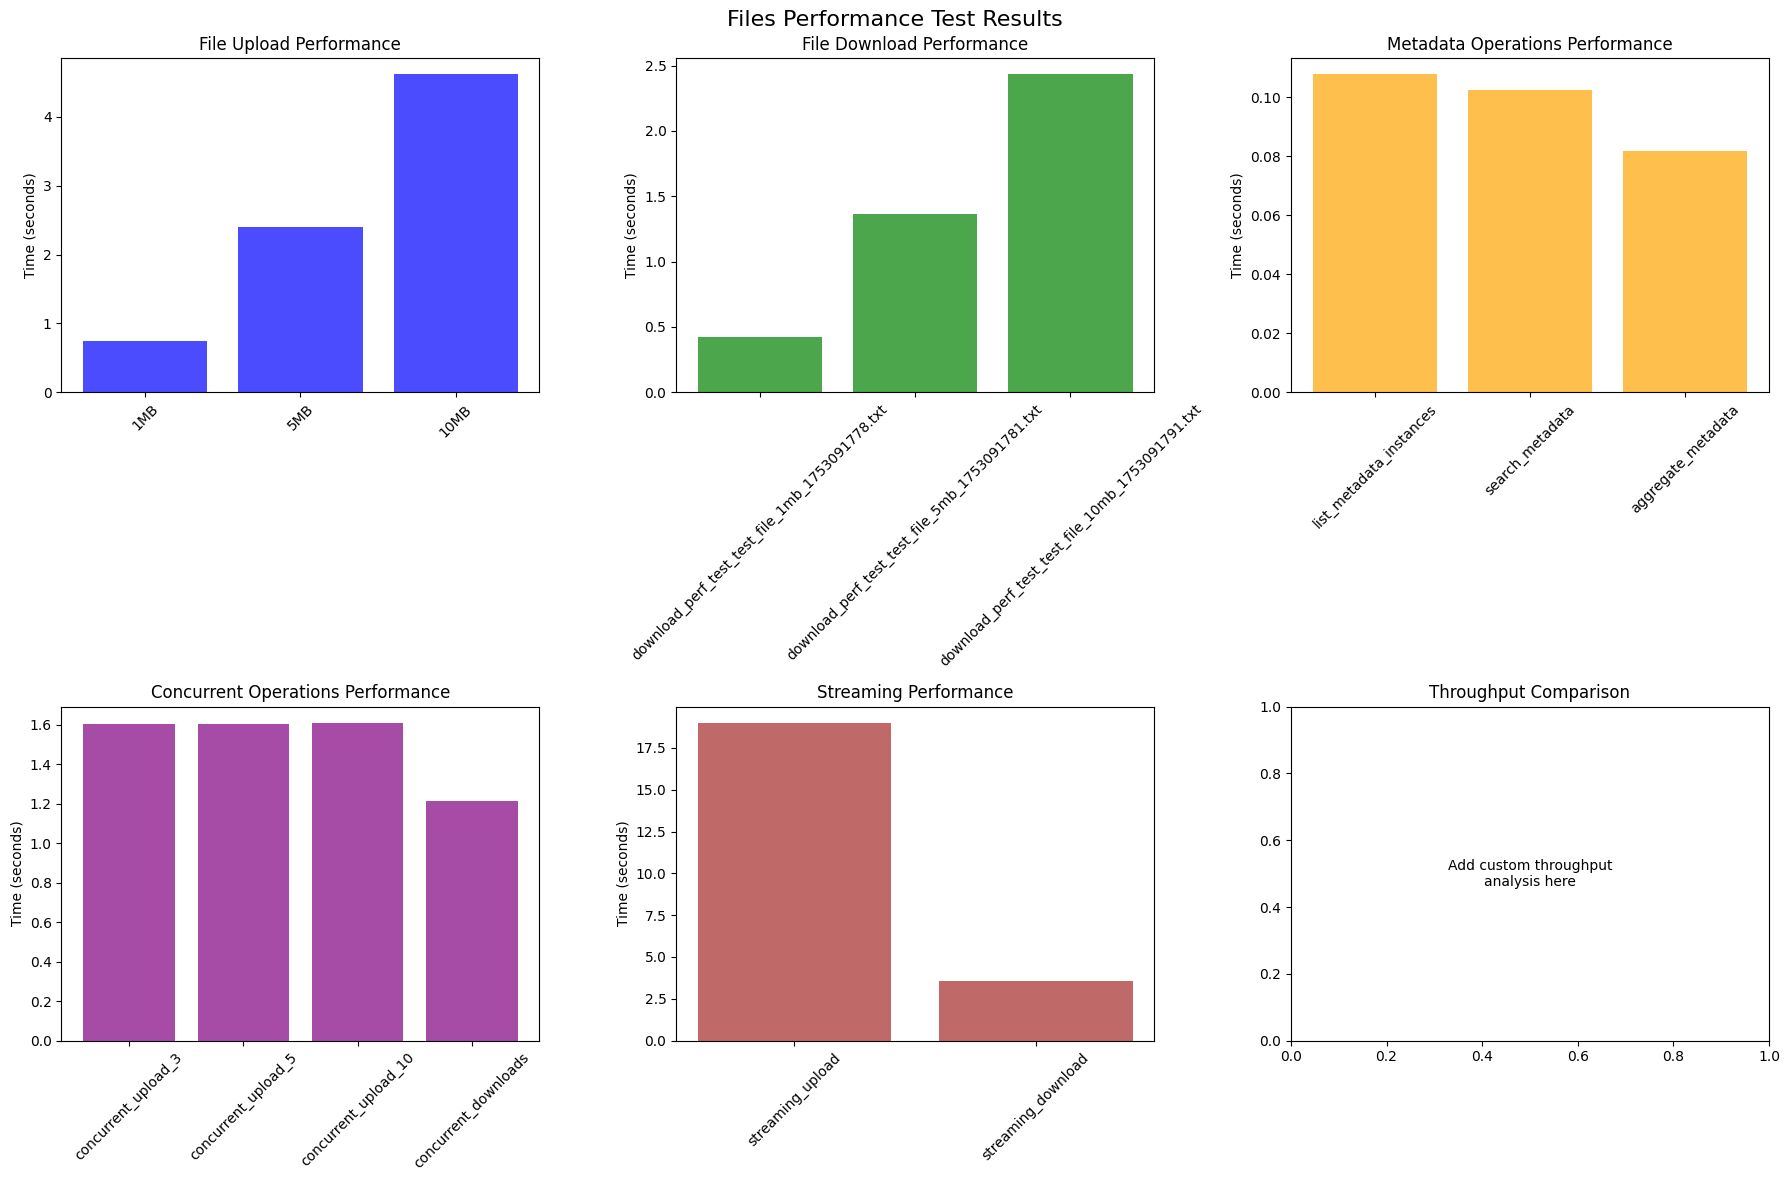


✅ Files performance testing complete!
💾 Results can be saved using the PerformanceTracker.save_results() method


In [13]:
# Performance Results Summary and Visualization
def summarize_and_visualize_files_results():
    """Summarize all files performance test results and create visualizations."""
    
    print("📈 Files Performance Test Results Summary")
    print("=" * 60)
    
    # Summarize each test
    if 'upload_results' in globals() and upload_results:
        print("\n📤 File Upload Performance:")
        for test_name, results in upload_results.items():
            if results and test_name != 'uploaded_file_ids':
                print(f"  {test_name:20} | {results['mean_time']:.2f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    if 'download_results' in globals() and globals().get('download_results'):
        print("\n📥 File Download Performance:")
        for test_name, results in globals().get('download_results', {}).items():
            if results:
                print(f"  {test_name:20} | {results['mean_time']:.2f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    if 'metadata_results' in globals() and metadata_results:
        print("\n📋 Data Modeling Metadata Operations Performance:")
        for test_name, results in metadata_results.items():
            if results:
                print(f"  {test_name:25} | {results['mean_time']:.4f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    if 'concurrent_results' in globals() and concurrent_results:
        print("\n🔄 Concurrent Operations Performance:")
        for test_name, results in concurrent_results.items():
            if results:
                print(f"  {test_name:20} | {results['mean_time']:.2f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    if 'streaming_results' in globals() and streaming_results:
        print("\n🌊 Streaming Operations Performance:")
        for test_name, results in streaming_results.items():
            if results:
                print(f"  {test_name:20} | {results['mean_time']:.2f}s avg | {results['operations_per_second']:.2f} ops/s")
    
    # Create visualization if matplotlib is available
    if PLOTTING_AVAILABLE:
        try:
            import matplotlib.pyplot as plt
            
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            fig.suptitle('Files Performance Test Results', fontsize=16)
            
            # Plot 1: Upload Performance
            if 'upload_results' in globals() and upload_results:
                ax = axes[0, 0]
                upload_tests = [name for name, results in upload_results.items() 
                              if results and name != 'uploaded_file_ids']
                upload_times = [upload_results[name]['mean_time'] for name in upload_tests]
                
                if upload_tests:
                    ax.bar([name.replace('upload_', '').replace('mb', 'MB') for name in upload_tests], 
                           upload_times, color='blue', alpha=0.7)
                    ax.set_title('File Upload Performance')
                    ax.set_ylabel('Time (seconds)')
                    ax.tick_params(axis='x', rotation=45)
            
            # Plot 2: Download Performance
            if 'download_results' in globals() and globals().get('download_results'):
                ax = axes[0, 1]
                download_results_data = globals().get('download_results', {})
                download_tests = [name for name, results in download_results_data.items() if results]
                download_times = [download_results_data[name]['mean_time'] for name in download_tests]
                
                if download_tests:
                    ax.bar(download_tests, download_times, color='green', alpha=0.7)
                    ax.set_title('File Download Performance')
                    ax.set_ylabel('Time (seconds)')
                    ax.tick_params(axis='x', rotation=45)
            
            # Plot 3: Metadata Operations
            if 'metadata_results' in globals() and metadata_results:
                ax = axes[0, 2]
                metadata_tests = [name for name, results in metadata_results.items() if results]
                metadata_times = [metadata_results[name]['mean_time'] for name in metadata_tests]
                
                if metadata_tests:
                    ax.bar(metadata_tests, metadata_times, color='orange', alpha=0.7)
                    ax.set_title('Metadata Operations Performance')
                    ax.set_ylabel('Time (seconds)')
                    ax.tick_params(axis='x', rotation=45)
            
            # Plot 4: Concurrent Operations
            if 'concurrent_results' in globals() and concurrent_results:
                ax = axes[1, 0]
                concurrent_tests = [name for name, results in concurrent_results.items() if results]
                concurrent_times = [concurrent_results[name]['mean_time'] for name in concurrent_tests]
                
                if concurrent_tests:
                    ax.bar(concurrent_tests, concurrent_times, color='purple', alpha=0.7)
                    ax.set_title('Concurrent Operations Performance')
                    ax.set_ylabel('Time (seconds)')
                    ax.tick_params(axis='x', rotation=45)
            
            # Plot 5: Streaming Performance
            if 'streaming_results' in globals() and streaming_results:
                ax = axes[1, 1]
                streaming_tests = [name for name, results in streaming_results.items() if results]
                streaming_times = [streaming_results[name]['mean_time'] for name in streaming_tests]
                
                if streaming_tests:
                    ax.bar(streaming_tests, streaming_times, color='brown', alpha=0.7)
                    ax.set_title('Streaming Performance')
                    ax.set_ylabel('Time (seconds)')
                    ax.tick_params(axis='x', rotation=45)
            
            # Plot 6: Throughput Comparison (if available)
            ax = axes[1, 2]
            ax.set_title('Throughput Comparison')
            ax.text(0.5, 0.5, 'Add custom throughput\nanalysis here', 
                   ha='center', va='center', transform=ax.transAxes)
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"\n📊 Visualization error: {e}")
    else:
        print("\n📊 Install matplotlib for visualizations: pip install matplotlib")
    
    print(f"\n✅ Files performance testing complete!")
    print(f"💾 Results can be saved using the PerformanceTracker.save_results() method")

# Generate summary
summarize_and_visualize_files_results()


In [14]:
# Complete Cleanup Function - Always Full Cleanup

def cleanup_all_resources():
    """Clean up ALL test files and data modeling resources (complete cleanup)."""
    
    if client is None:
        print("❌ Cannot cleanup: Client not available.")
        return
    
    # Import required classes
    from cognite.client.data_classes.data_modeling import ViewId
    
    print("🧹 Starting COMPLETE cleanup of all test resources...")
    print("⚠️ This will remove files, instances, containers, views, data models, and space!")
    print("=" * 70)
    
    total_stats = {
        "files_deleted": 0, 
        "dm_instances_deleted": 0, 
        "models_deleted": 0, 
        "views_deleted": 0, 
        "containers_deleted": 0, 
        "spaces_deleted": 0, 
        "errors": 0
    }
    
    try:
        # STEP 1: Clean up data modeling instances first
        print("🔹 STEP 1: Cleaning data modeling instances...")
        if USE_DATA_MODELING and client is not None:
            try:
                # First check if the view exists before trying to query instances with it
                views = client.data_modeling.views.list(space=DATA_MODEL_SPACE)
                view_exists = any(v.external_id == VIEW_EXTERNAL_ID and v.version == VIEW_VERSION for v in views)
                
                if view_exists:
                    # Use view-specific query if view exists
                    instances = client.data_modeling.instances.list(
                        instance_type="node",
                        sources=[ViewId(space=DATA_MODEL_SPACE, external_id=VIEW_EXTERNAL_ID, version=VIEW_VERSION)],
                        limit=1000
                    )
                else:
                    # Fallback: list all instances in the space
                    print("    View doesn't exist, listing all instances in space...")
                    instances = client.data_modeling.instances.list(
                        instance_type="node",
                        limit=1000
                    )
                    # Filter to only instances in our space
                    instances = [inst for inst in instances if inst.space == DATA_MODEL_SPACE]
                
                if instances:
                    instance_ids = [(inst.space, inst.external_id) for inst in instances]
                    batch_size = 100
                    for i in range(0, len(instance_ids), batch_size):
                        batch = instance_ids[i:i + batch_size]
                        client.data_modeling.instances.delete(batch)
                        total_stats["dm_instances_deleted"] += len(batch)
                        print(f"    Deleted {len(batch)} data modeling instances")
                else:
                    print("    No data modeling instances found")
                        
            except Exception as e:
                print(f"    ⚠️ Warning cleaning data modeling instances: {e}")
                total_stats["errors"] += 1
        else:
            print("    Skipping data modeling instances (not available)")
        
        # STEP 2: Clean up files from Files API
        print("\n🔹 STEP 2: Cleaning files from Files API...")
        test_sources = ["performance_test", "concurrent_performance_test", "streaming_performance_test"]
        
        for source in test_sources:
            try:
                files = client.files.list(source=source, limit=1000)
                if files:
                    file_ids = [f.id for f in files]
                    batch_size = 100
                    for i in range(0, len(file_ids), batch_size):
                        batch = file_ids[i:i + batch_size]
                        client.files.delete(id=batch)
                        total_stats["files_deleted"] += len(batch)
                        print(f"    Deleted {len(batch)} files from source: {source}")
                else:
                    print(f"    No files found for source: {source}")
                
            except Exception as e:
                print(f"    ⚠️ Warning cleaning {source}: {e}")
                total_stats["errors"] += 1
        
        # Also clean up tracked uploaded files
        if 'upload_results' in globals() and upload_results and 'uploaded_file_ids' in upload_results:
            try:
                file_ids = upload_results['uploaded_file_ids']
                if file_ids:
                    client.files.delete(id=file_ids)
                    total_stats["files_deleted"] += len(file_ids)
                    print(f"    Deleted {len(file_ids)} tracked uploaded files")
            except Exception as e:
                print(f"    ⚠️ Warning cleaning tracked files: {e}")
                total_stats["errors"] += 1

        # STEP 3: Clean up data models
        print("\n🔹 STEP 3: Cleaning data models...")
        try:
            models = client.data_modeling.data_models.list(space=DATA_MODEL_SPACE)
            models_found = [m for m in models if m.external_id == DATA_MODEL_EXTERNAL_ID]
            if models_found:
                for model in models_found:
                    client.data_modeling.data_models.delete([(DATA_MODEL_SPACE, model.external_id, model.version)])
                    total_stats["models_deleted"] += 1
                    print(f"    ✅ Deleted data model: {model.external_id}")
            else:
                print("    No target data models found")
        except Exception as e:
            print(f"    ⚠️ Warning deleting data models: {e}")
            total_stats["errors"] += 1
        
        # STEP 4: Clean up views
        print("\n🔹 STEP 4: Cleaning views...")
        try:
            views = client.data_modeling.views.list(space=DATA_MODEL_SPACE)
            views_found = [v for v in views if v.external_id == VIEW_EXTERNAL_ID]
            if views_found:
                for view in views_found:
                    client.data_modeling.views.delete([(DATA_MODEL_SPACE, view.external_id, view.version)])
                    total_stats["views_deleted"] += 1
                    print(f"    ✅ Deleted view: {view.external_id}")
            else:
                print("    No target views found")
        except Exception as e:
            print(f"    ⚠️ Warning deleting views: {e}")
            total_stats["errors"] += 1
        
        # STEP 5: Clean up containers
        print("\n🔹 STEP 5: Cleaning containers...")
        try:
            containers = client.data_modeling.containers.list(space=DATA_MODEL_SPACE)
            containers_found = [c for c in containers if c.external_id == "file_metadata_container"]
            if containers_found:
                for container in containers_found:
                    client.data_modeling.containers.delete([(DATA_MODEL_SPACE, container.external_id)])
                    total_stats["containers_deleted"] += 1
                    print(f"    ✅ Deleted container: {container.external_id}")
            else:
                print("    No target containers found")
        except Exception as e:
            print(f"    ⚠️ Warning deleting containers: {e}")
            total_stats["errors"] += 1
        
        # STEP 6: Clean up space
        print("\n🔹 STEP 6: Cleaning space...")
        try:
            client.data_modeling.spaces.delete([DATA_MODEL_SPACE])
            total_stats["spaces_deleted"] += 1
            print(f"    ✅ Deleted space: {DATA_MODEL_SPACE}")
        except Exception as e:
            print(f"    ⚠️ Warning deleting space: {e}")
            total_stats["errors"] += 1
    
    except Exception as e:
        print(f"❌ Error during cleanup: {e}")
        total_stats["errors"] += 1
    
    # Final summary
    print("\n" + "=" * 70)
    print("✅ COMPLETE CLEANUP FINISHED!")
    print("📊 Summary:")
    print(f"  📁 Files deleted: {total_stats['files_deleted']}")
    print(f"  📋 Data instances deleted: {total_stats['dm_instances_deleted']}")
    print(f"  🏗️ Data models deleted: {total_stats['models_deleted']}")
    print(f"  👁️ Views deleted: {total_stats['views_deleted']}")
    print(f"  📦 Containers deleted: {total_stats['containers_deleted']}")
    print(f"  🏠 Spaces deleted: {total_stats['spaces_deleted']}")
    print(f"  ⚠️ Errors encountered: {total_stats['errors']}")
    print("=" * 70)

# Usage Instructions  
print("🧹 COMPLETE CLEANUP FUNCTION READY")
print("=" * 50)
print("")
print("💡 To run complete cleanup:")
print("   1. Uncomment the line below")
print("   2. Run this cell")
print("   3. Check the summary report")
print("")
print("⚠️ WARNING: This removes EVERYTHING!")
print("   - All test files and data modeling resources")
print("   - Cannot be undone")
print("   - Use only when completely done with testing")
print("")
print("🚀 Uncomment to run:")
print("# cleanup_all_resources()")

# Uncomment the line below to run complete cleanup:
cleanup_all_resources()


🧹 COMPLETE CLEANUP FUNCTION READY

💡 To run complete cleanup:
   1. Uncomment the line below
   2. Run this cell
   3. Check the summary report

⚠️ WARNING: This removes EVERYTHING!
   - All test files and data modeling resources
   - Cannot be undone
   - Use only when completely done with testing

🚀 Uncomment to run:
# cleanup_all_resources()
🧹 Starting COMPLETE cleanup of all test resources...
⚠️ This will remove files, instances, containers, views, data models, and space!
🔹 STEP 1: Cleaning data modeling instances...
    Deleted 24 data modeling instances

🔹 STEP 2: Cleaning files from Files API...
    Deleted 24 files from source: performance_test
    Deleted 100 files from source: concurrent_performance_test
    Deleted 100 files from source: concurrent_performance_test
    Deleted 100 files from source: concurrent_performance_test
    Deleted 24 files from source: concurrent_performance_test
    Deleted 3 files from source: streaming_performance_test
    ⚠️ Warning cleaning trac